# DMT
Mazeworld with discrete morse theory

In [1]:
import sys

sys.path.append("../src")

from environments import MazeEnv
from policies import BaseAgent, QLearningAgent
from dmt import environment_to_graph, classify_simplices, visualize_graph

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
env = MazeEnv()
agent = BaseAgent(env, gamma=1)
agent.value_iteration()
optimal_value_function = agent.value_function

In [3]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=1, alpha=0.1)
agent.compute_optimal_q_function()
optimal_q_function = agent.q_table

Optimal Q-function computed.


In [4]:
# check if max_a q_{opt}(s, a) == v_{opt{(s)
np.all(np.max(agent.q_table, axis=-1) == optimal_value_function)

True

# Env to graph
Convert a gymnasium environment to a graph. We connected states $s$, $s'$ with an edge if an action at $s$ can take us to $s'$.

We simplify and assume an undirected graph.

We also assign a real-valued function on the graph as determined by the value function.

The environment has slight arbitrariness in its rewards to ensure that the value function is a morse function.

In [5]:
G = environment_to_graph(env, optimal_q_function)

In [6]:
list(G.nodes(data=True))[:5]

[(0, {'node_value': -21.998798}),
 (1, {'node_value': -19.998856}),
 (2, {'node_value': -18.998916}),
 (3, {'node_value': -17.998918}),
 (4, {'node_value': -1.999991})]

In [7]:
list(G.edges(data=True))[:5]

[(0, 10, {'edge_value': -21.998798}),
 (1, 11, {'edge_value': -19.998856}),
 (1, 2, {'edge_value': -19.998915}),
 (2, 3, {'edge_value': -18.998916}),
 (3, 12, {'edge_value': -17.998918})]

# Basic Morse theory

Compute all critical/regular nodes/edges.



In [8]:
# Run the classification function
critical_nodes, regular_nodes, critical_edges, regular_edges = classify_simplices(G)

# Check if it's a discrete Morse function and print the results
if critical_nodes is not None:
    print("Discrete Morse function found")
    print("Critical Nodes:", critical_nodes)
    print("Regular Nodes:", regular_nodes)
    print("Critical Edges:", critical_edges)
    print("Regular Edges:", regular_edges)
else:
    print("Not a discrete Morse function")

Discrete Morse function found
Critical Nodes: [(6, {'node_value': 0.0}), (93, {'node_value': 0.0})]
Regular Nodes: [(0, {'node_value': -21.998798}), (1, {'node_value': -19.998856}), (2, {'node_value': -18.998916}), (3, {'node_value': -17.998918}), (4, {'node_value': -1.999991}), (5, {'node_value': -0.999995}), (7, {'node_value': -0.999993}), (8, {'node_value': -1.9999850000000001}), (9, {'node_value': -2.999976}), (10, {'node_value': -20.998798}), (11, {'node_value': -18.998857}), (12, {'node_value': -16.998921}), (13, {'node_value': -2.999978}), (14, {'node_value': -0.999986}), (15, {'node_value': -3.9999610000000003}), (16, {'node_value': -19.998808}), (17, {'node_value': -17.998868}), (18, {'node_value': -15.998933}), (19, {'node_value': -3.999959}), (20, {'node_value': -1.9999660000000001}), (21, {'node_value': -2.9999450000000003}), (22, {'node_value': -3.9999230000000003}), (23, {'node_value': -4.9999}), (24, {'node_value': -18.998824}), (25, {'node_value': -17.998853999999998}),

# Visualization

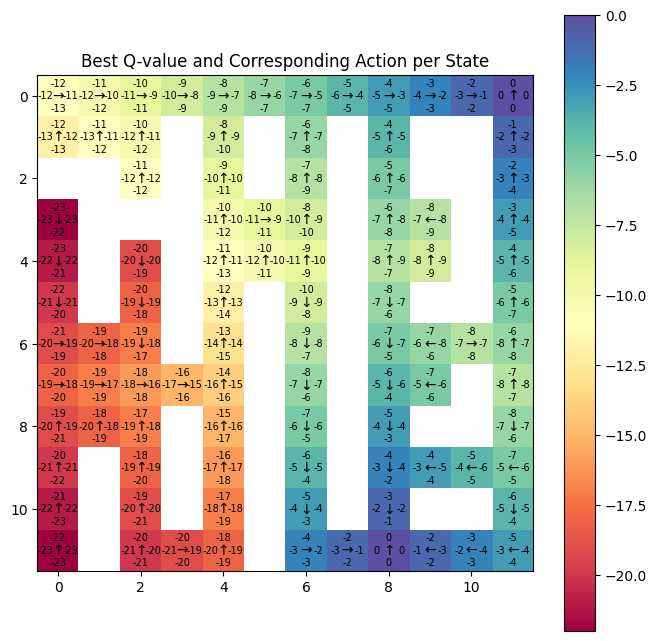

In [9]:
agent.plot_best_action_q_values()

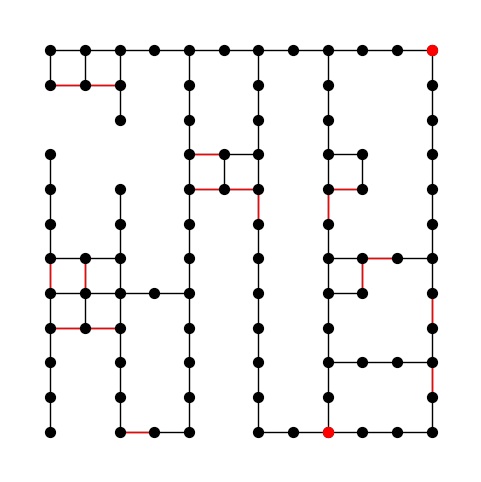

In [10]:
visualize_graph(G, env, critical_nodes, critical_edges)

In [11]:
from dmt import get_induced_gradient_vector_field, visualize_induced_vector_field

V = get_induced_gradient_vector_field(G)

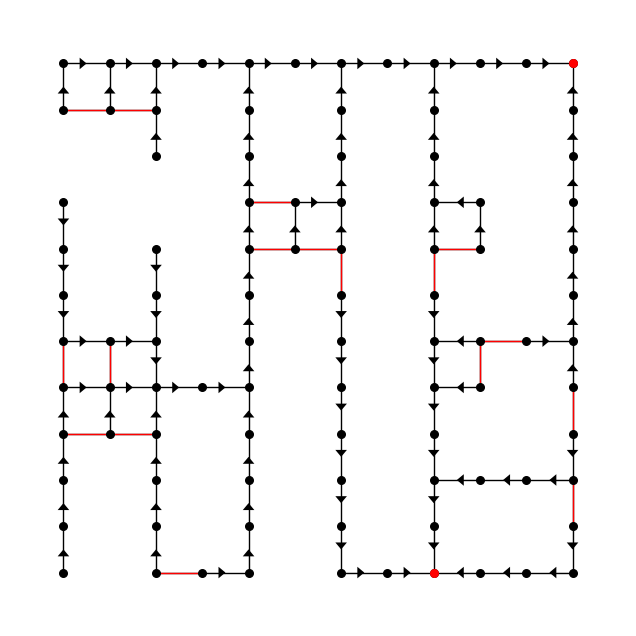

In [12]:
visualize_induced_vector_field(G, env, critical_nodes, critical_edges, V)

# Homology

Assume R coefficients.

In [13]:
from dmt import boundary_operator_r, betti_numbers

In [14]:
import seaborn as sns

<Axes: >

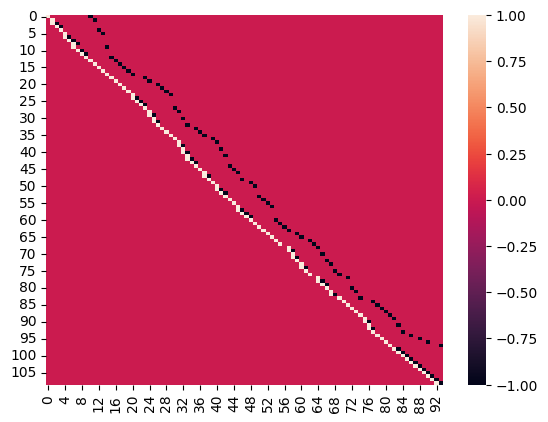

In [15]:
D = boundary_operator_r(G)
sns.heatmap(D)

In [16]:
def betti_numbers(G):
    D = boundary_operator_r(G)
    rank = np.linalg.matrix_rank(D)
    b_0 = D.shape[1] - rank
    b_1 = D.shape[0] - rank
    return b_0, b_1

In [17]:
b0, b1 = betti_numbers(G)

In [18]:
m0 = len(critical_nodes)
m1 = len(critical_edges)
chi = m0 - m1
print(chi)

-15


In [19]:
def euler_characteristic(G):
    V = G.number_of_nodes()
    E = G.number_of_edges()
    return V - E

In [20]:
euler_characteristic(G)

-15

# Homological sequences

For each critical value, compute the Betti numbers of the subcomplex of the graph.

Assumes the graph case for now.

In [21]:
def subcomplex(G, c):
    # Get the nodes whose Morse function value is less than or equal to c
    nodes = [node[0] for node in G.nodes(data=True) if -node[1]["node_value"] <= c]
    # Get the edges whose Morse function value is less than or equal to c
    edges = [edge[:2] for edge in G.edges(data=True) if -edge[2]["edge_value"] <= c]
    # Return the subgraph of G induced by these nodes and edges
    return G.edge_subgraph(edges).subgraph(nodes)

In [22]:
critical_values = [-v[-1]['node_value'] for v in critical_nodes] + [-e[-1]['edge_value'] for e in critical_edges]
critical_values = sorted(set(critical_values))

In [23]:
for c in critical_values:
    try:
        print(
            f"{betti_numbers(subcomplex(G, c))},\t {c:.02f})")
    except:
        pass

(2, 1),	 5.00)
(2, 2),	 6.00)
(1, 2),	 7.00)
(1, 3),	 7.00)
(1, 4),	 7.00)
(1, 5),	 8.00)
(1, 6),	 9.00)
(1, 7),	 10.00)
(1, 8),	 10.00)
(1, 9),	 11.00)
(1, 10),	 11.00)
(1, 11),	 12.00)
(1, 12),	 18.00)
(1, 13),	 18.00)
(1, 14),	 19.00)
(1, 15),	 19.00)
(1, 16),	 20.00)
